In [2]:
import openvino as ov
core = ov.Core()
model = core.read_model(model='models/face-detection-adas-0001.xml')
compiled_model = core.compile_model(model = model, device_name="CPU")
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)
print("input: ", input_layer.shape)
print("input: ", output_layer.shape)

input:  [1,3,384,672]
input:  [1,1,200,7]


# preproc

(4000, 4684, 3)


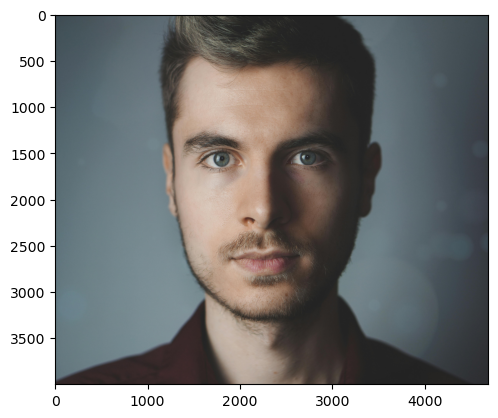

In [10]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("person.jpg")
print(image.shape)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
image_height, image_width, image_channels = image.shape
image = cv2.resize(image, (int(image_width/5), int(image_height/5)))
cv2.imshow("Image", image)
cv2.waitKey()
cv2.destroyAllWindows()

In [43]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("persons.jpg")

In [14]:
import numpy as np
def preprocess(image):
    N, input_channels, input_height, input_width = input_layer.shape
    resized_image = cv2.resize(image, (input_width, input_height))
    transposed_image = resized_image.transpose(2, 0, 1)
    input_image = np.expand_dims(transposed_image, 0)
    return input_image

# run inference

In [44]:
input_image = preprocess(image)

In [45]:
results = compiled_model([input_image])[output_layer]

In [29]:
results - np.squeeze(results)
print(np.shape(results))
print(results)

(1, 1, 200, 7)
[[[[0.         1.         0.99963295 ... 0.12187105 0.7076365
    0.82816553]
   [0.         1.         0.03388567 ... 0.39402097 0.9355192
    0.47146934]
   [0.         1.         0.03333464 ... 0.37785903 0.97652406
    0.5069595 ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]]]


# squeeze 는 추가 차원 제거 (1, 1, 200, 7) -> (200, 7)

In [31]:
print(results[0][0][-1])

[0. 0. 0. 0. 0. 0. 0.]


# postprecess

In [50]:
def find_faceboxes(image, results, confidence_threshold):
    results = results.squeeze()
    scores = results[:,2]
    boxes = results[:,-4:]
    face_boxes = boxes[scores >= confidence_threshold]
    scores = scores[scores >= confidence_threshold]
    image_h, image_w, image_channels = image.shape
    face_boxes = face_boxes*np.array([image_w, image_h, image_w, image_h])
    face_boxes = face_boxes.astype(np.int64)
    return face_boxes, scores

In [61]:
confidence_threshold = .05
face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
print (face_boxes)

[[1008  982 1218 1219]
 [5822 1242 5982 1437]
 [3248 1220 3414 1397]
 [2469 1324 2632 1498]
 [5066 1425 5243 1632]
 [3054 1233 3210 1411]
 [4450 1440 4601 1613]
 [3700 1288 3853 1469]
 [4963 1214 5127 1397]
 [1514 1355 1662 1526]
 [4752 1278 4912 1461]
 [4861 1473 5019 1667]]


In [39]:
print(scores)

[0.99963295]


In [63]:
def draw_faceboxes(image, face_boxes, scores):
    show_image = image.copy()
    for i in range(len(face_boxes)):
        xmin, ymin, xmax, ymax = face_boxes[i]
        cv2.rectangle(img=show_image, pt1=(xmin,ymin), pt2=(xmax,ymax), color=(0,0,255), thickness=30)
    return show_image

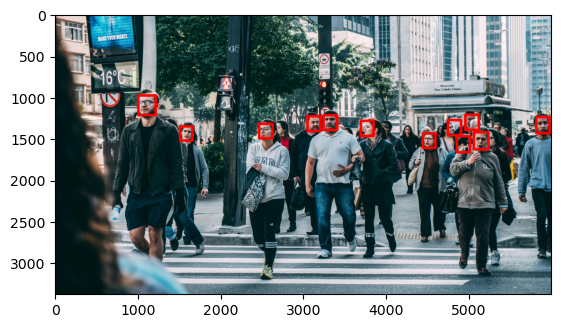

In [64]:
show_image = draw_faceboxes(image, face_boxes, scores)
plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))